In [7]:
# Load the images
from PIL import Image
import numpy as np

for i in range(1, 500):
    try:
        image1 = Image.open(f'data/image/spots_validation/validation/{i}.jpg')
        image2 = Image.open(f'/home/anlt69/Desktop/ST_SIM/SD_model_7Nov2024/SD_7Nov2024/Results/SD_12Nov2024_fake/fake_image_{i}.png')
    
        # Convert images to numpy arrays
        image1_array = np.array(image1)
        image2_array = np.array(image2)
    
        # Concatenate images horizontally
        concatenated_image_array = np.concatenate((image1_array, image2_array), axis=1)
    
        # Convert the concatenated array back to an image
        concatenated_image = Image.fromarray(concatenated_image_array)
    
        # Save the concatenated image
        concatenated_image.save(f'result/val_{i}_comparison.png')
    except:
        print(f"Error in image {i}")


In [ ]:
import re
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Initialize lists for storing the losses
epochs = []
mse_loss = []
diversity_loss = []
consistency_loss = []
total_loss = []

# Read the .log file and extract loss values
with open("/home/anlt69/Desktop/ST_SIM/SD_model_7Nov2024/SD_7Nov2024/Results/training.log", "r") as file:
    for line in file:
        match = re.search(
            r'\[Epoch (\d+)/\d+\] \[Batch \d+/\d+\] \[MSE_Loss: ([\d.]+)\] \[Diversity_Loss: ([\d.]+)\] \[Consistency_Loss: ([\d.]+)\] \[Total_Loss: ([\d.]+)\]',
            line
        )
        if match:
            epochs.append(int(match.group(1)))
            mse_loss.append(float(match.group(2)))
            diversity_loss.append(float(match.group(3)))
            consistency_loss.append(float(match.group(4)))
            total_loss.append(float(match.group(5)))

# Apply Gaussian filter to smooth the loss values
mse_loss_smooth = gaussian_filter1d(mse_loss, sigma=2)
diversity_loss_smooth = gaussian_filter1d(diversity_loss, sigma=2)
consistency_loss_smooth = gaussian_filter1d(consistency_loss, sigma=2)
total_loss_smooth = gaussian_filter1d(total_loss, sigma=2)

# Plotting the losses with smooth lines
plt.figure(figsize=(15, 6))
plt.plot(epochs, mse_loss, label="MSE Loss", marker='o')
plt.plot(epochs, mse_loss_smooth, label="MSE Loss (Smooth)", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MSE loss")
plt.title("MSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(epochs, diversity_loss, label="Diversity Loss", marker='o')
plt.plot(epochs, diversity_loss_smooth, label="Diversity Loss (Smooth)", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Diversity Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(epochs, consistency_loss, label="Consistency Loss", marker='o')
plt.plot(epochs, consistency_loss_smooth, label="Consistency Loss (Smooth)", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Consistency Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(epochs, total_loss, label="Total Loss", marker='o')
plt.plot(epochs, total_loss_smooth, label="Total Loss (Smooth)", linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Total Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

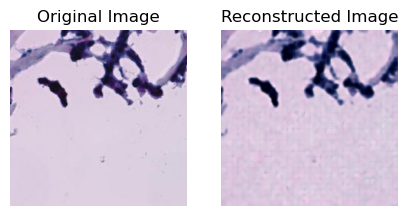

MSE: 96.95960489908855


In [61]:
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
from skimage.metrics import mean_squared_error, structural_similarity as ssim

from vae_model import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(in_channels=3, latent_dim=4, image_size=256).to(device)
vae.load_state_dict(torch.load('vae_model.pth', map_location=torch.device('cpu')))
vae.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

original_image = Image.open('data/image/spots_train/train/466.jpg').convert('RGB')
# original_image = Image.open('data/image/spots_validation/validation/464.jpg').convert('RGB')
image = transform(original_image).unsqueeze(0).to(device)

# Predict the image
with torch.no_grad():
    reconstructed_image, _, _, _ = vae(image)
    mu, log_var = vae.encode(image)
    encoded_vector = vae.reparameterize(mu, log_var)

# Convert the output tensor to an image
reconstructed_image = reconstructed_image.squeeze(0).cpu()
reconstructed_image = (reconstructed_image * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]
reconstructed_image = transforms.ToPILImage()(reconstructed_image)

image = image.squeeze(0).cpu().permute(1, 2, 0)
image = (image * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_image)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

mse_value = mean_squared_error(np.array(original_image), np.array(reconstructed_image))
print('MSE:', mse_value)


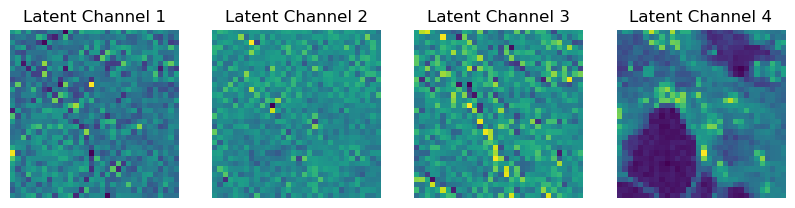

In [57]:
# Load and preprocess the image
original_image = Image.open('data/image/spots_validation/validation/466.jpg').convert('RGB')
image = transform(original_image).unsqueeze(0).to(device)

# Encode the image to get the latent representation
with torch.no_grad():
    mu, log_var = vae.encode(image)
    encoded_vector = vae.reparameterize(mu, log_var)

# Convert the latent representation to a numpy array
encoded_vector = encoded_vector.squeeze(0).cpu().numpy()

# Plot the four channels of the latent representation
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
    axes[i].imshow(encoded_vector[i])
    axes[i].set_title(f'Latent Channel {i+1}')
    axes[i].axis('off')


In [3]:
for i in range(10):
    original_image = Image.open(f'data/image/spots_train/train/{i}.jpg').convert('RGB')
    image = transform(original_image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        reconstructed_image, _, _, _ = vae(image)
        mu, log_var = vae.encode(image)
        encoded_vector = vae.reparameterize(mu, log_var)*
    
    reconstructed_image = reconstructed_image.squeeze(0).cpu()
    reconstructed_image = (reconstructed_image * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]
    reconstructed_image = transforms.ToPILImage()(reconstructed_image)
    concatenated_image = Image.new('RGB', (original_image.width + reconstructed_image.width, original_image.height))
    concatenated_image.paste(original_image, (0, 0))
    concatenated_image.paste(reconstructed_image, (original_image.width, 0))

    # output_path = f'result/vae_validation/val_{i}_comparison.png'
    # concatenated_image.save(output_path)
    reconstructed_image.save(f'result/vae_train/reconstructed_{i}.png')

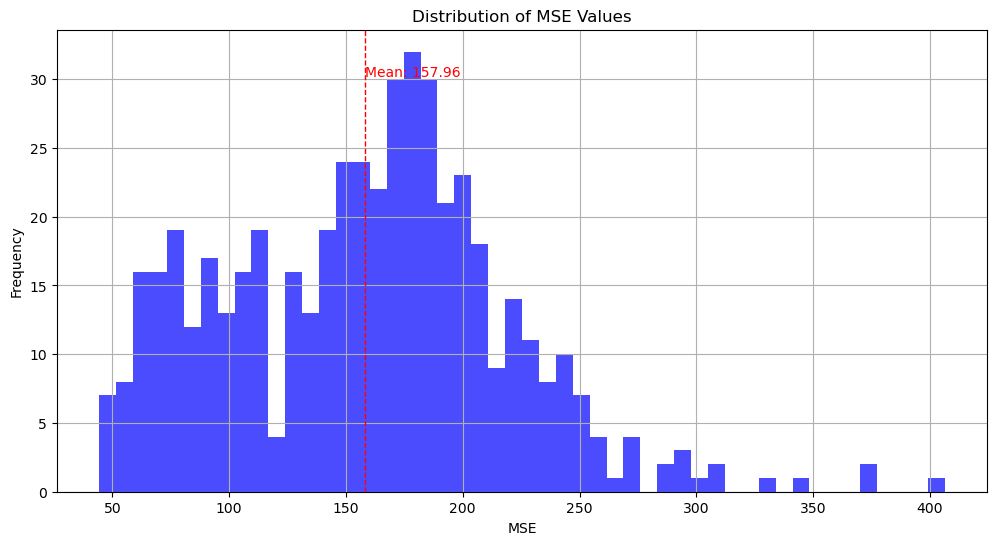

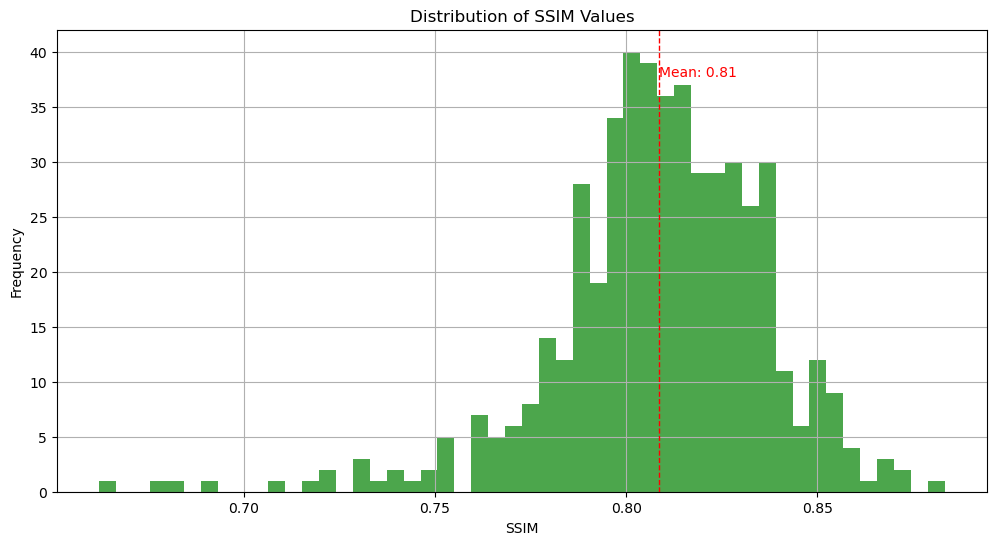

In [7]:
import os
import torch
from PIL import Image
from torchvision import transforms
from skimage.metrics import mean_squared_error, structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

from vae_model import VAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(in_channels=3, latent_dim=4, image_size=256).to(device)
vae.load_state_dict(torch.load('vae_model.pth', map_location=torch.device('cpu')))
vae.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mse_values = []
ssim_values = []

for i in range(500):
    original_image = Image.open(f'data/image/spots_validation/validation/{i}.jpg').convert('RGB')
    image = transform(original_image).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed_image, _, _, _ = vae(image)
        mu, log_var = vae.encode(image)
        encoded_vector = vae.reparameterize(mu, log_var)

    reconstructed_image = reconstructed_image.squeeze(0).cpu()
    reconstructed_image = (reconstructed_image * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]
    reconstructed_image = transforms.ToPILImage()(reconstructed_image)

    concatenated_image = Image.new('RGB', (original_image.width + reconstructed_image.width, original_image.height))
    concatenated_image.paste(original_image, (0, 0))
    concatenated_image.paste(reconstructed_image, (original_image.width, 0))

    # Convert images to numpy arrays
    original_image_array = np.array(original_image)
    reconstructed_image_array = np.array(reconstructed_image)

    # Calculate MSE
    mse_value = mean_squared_error(original_image_array, reconstructed_image_array)

    # Calculate SSIM with specified win_size and channel_axis
    ssim_value = ssim(original_image_array, reconstructed_image_array, win_size=7, channel_axis=2)

    mse_values.append(mse_value)
    ssim_values.append(ssim_value)

# Calculate means
mean_mse = np.mean(mse_values)
mean_ssim = np.mean(ssim_values)

# Plot the distribution of MSE values
plt.figure(figsize=(12, 6))
plt.hist(mse_values, bins=50, color='blue', alpha=0.7)
plt.axvline(mean_mse, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_mse, plt.ylim()[1] * 0.9, f'Mean: {mean_mse:.2f}', color='red')
plt.title('Distribution of MSE Values')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the distribution of SSIM values
plt.figure(figsize=(12, 6))
plt.hist(ssim_values, bins=50, color='green', alpha=0.7)
plt.axvline(mean_ssim, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_ssim, plt.ylim()[1] * 0.9, f'Mean: {mean_ssim:.2f}', color='red')
plt.title('Distribution of SSIM Values')
plt.xlabel('SSIM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
image = Image.open('/home/anlt69/Desktop/study/gan_model/data/image/spots_validation/validation/499.jpg').convert('RGB')
image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae = VAE(in_channels=3, latent_dim=4, image_size=256).to(device)
vae.load_state_dict(torch.load('vae_model.pth', map_location=torch.device('cpu')))
vae.eval()

latent_vector = torch.randn(1, 4, 32, 32).to(device)

with torch.no_grad():
    decoded_image = vae.decode(latent_vector)

decoded_image = decoded_image.squeeze(0).cpu()
decoded_image = (decoded_image * 0.5) + 0.5  # Convert from [-1, 1] to [0, 1]
decoded_image = transforms.ToPILImage()(decoded_image)

plt.imshow(decoded_image)
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()